In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

In [2]:
station_data = pd.read_excel('datasets/station_data.xlsx', header=[0, 1])

# <center>Исследование влажности листьев</center>

<div style="float: centr; border: 1px dashed gray; padding: 5px 5px 0px 2px;">
    
&nbsp;&nbsp;&nbsp;<b>Входные данные:</b> 

Результаты измерения датчика влажности листьев, результаты метеорологических измерений (данные собирались синхронно с фиксацией влажности листьев в том же месте, где располагался датчик).


&nbsp;&nbsp;&nbsp;<b>Задача:</b>   
    
Оцените возможность определения влажности листьев без использования датчика 
    
&nbsp;&nbsp;&nbsp;<b>Итог:</b>     

Создать прототип модели, которая “предсказывает” влажность  листьев по косвенным данным (температура почвы, влажность воздуха и др.)

## Вступление

<b>Влажность листьев</b> - это метеорологический параметр, который описывает количество росы и осадков, оставшихся на поверхности. Он используется для мониторинга влажности листьев в сельскохозяйственных целях, таких как борьба с грибками и болезнями, для контроля ирригационных систем, а также для обнаружения тумана и условий росы, а также для раннего обнаружения дождя.

Существуют датчики для детекции влажности листьев. Датчик влажности листьев измеряет, если листья культуры были влажными и как долго это продолжалось. Датчик влажности листа работает путем измерения проводимости в фильтровальной бумаге. Фильтровальная бумага удерживается между двумя электродами из нержавеющей стали в прозрачном держателе. Использование прозрачного пластиката в качестве держателя снижает нагрев датчика, когда он подвергается воздействию прямых солнечных лучей.

На уровень влажности листьев также влияет состояние атмосферы вокруг листа, влажность, температура и солнечный свет, а также состояние почвы и её температура и влажность.

Для создания прототипа модели предсказания влажности листа предоставлен датасет с метеорологическими измерениями и измерениями влажности листа.

<code>station_data.xlsx</code> - исходный датасет с измерениями

In [3]:
station_data.head(5)

Unnamed: 0_level_0 Температура воздуха [°C]                   \
          Дата / время                  ср.знач максимум минимум   
0  2020-08-31 19:00:00                    19.74    19.82   19.68   
1  2020-08-31 18:00:00                    20.18    20.60   19.76   
2  2020-08-31 17:00:00                    20.57    21.09   20.33   
3  2020-08-31 16:00:00                    21.45    22.13   21.08   
4  2020-08-31 15:00:00                    20.61    21.07   20.24   

  Точка росы [°C]         Солнечная радиация [W/m2] VPD [kPa]          \
          ср.знач минимум                   ср.знач   ср.знач минимум   
0            16.7    16.3                       115      0.38    0.35   
1            17.5    16.5                       122      0.35    0.32   
2            17.3    16.8                       198      0.44    0.35   
3            17.4    16.7                       384      0.56    0.45   
4            16.5    16.0                       319      0.53    0.47   

  Влажность воздуха  [%]  ... Скорость ветра [m/s]           \
                 ср.знач  ...              ср.знач максимум   
0                  82.98  ...                  1.0      1.2   
1                  84.70  ...                  0.7      1.2   
2                  81.72  ...                  0.7      1.1   
3                  78.11  ...                  0.6      0.9   
4                  77.81  ...                  0.8      1.3   

  Влажность почвы [%] Температура почвы [°C]                   \
              ср.знач                ср.знач максимум минимум   
0               36.57                   19.2     21.2    18.0   
1               36.58                   18.3     19.4    17.2   
2               36.63                   18.5     19.5    17.2   
3               36.68                   18.5     19.5    17.2   
4               36.75                   19.0     21.1    17.1   

  Солнечная панель [mV]  АКБ [mV] АКБ2 [mV]  \
              последний последний последний   
0                  9058      6784      3643   
1                  9298      6793      3643   
2                  8349      6787      3643   
3                  9125      6778      3643   
4                  9605      6770      3643   

                                        
  Эталонная эвапотранспирация ET0 [mm]  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  

[5 rows x 24 columns]

In [4]:
station_data.head(5)

Unnamed: 0_level_0 Температура воздуха [°C]                   \
          Дата / время                  ср.знач максимум минимум   
0  2020-08-31 19:00:00                    19.74    19.82   19.68   
1  2020-08-31 18:00:00                    20.18    20.60   19.76   
2  2020-08-31 17:00:00                    20.57    21.09   20.33   
3  2020-08-31 16:00:00                    21.45    22.13   21.08   
4  2020-08-31 15:00:00                    20.61    21.07   20.24   

  Точка росы [°C]         Солнечная радиация [W/m2] VPD [kPa]          \
          ср.знач минимум                   ср.знач   ср.знач минимум   
0            16.7    16.3                       115      0.38    0.35   
1            17.5    16.5                       122      0.35    0.32   
2            17.3    16.8                       198      0.44    0.35   
3            17.4    16.7                       384      0.56    0.45   
4            16.5    16.0                       319      0.53    0.47   

  Влажность воздуха  [%]  ... Скорость ветра [m/s]           \
                 ср.знач  ...              ср.знач максимум   
0                  82.98  ...                  1.0      1.2   
1                  84.70  ...                  0.7      1.2   
2                  81.72  ...                  0.7      1.1   
3                  78.11  ...                  0.6      0.9   
4                  77.81  ...                  0.8      1.3   

  Влажность почвы [%] Температура почвы [°C]                   \
              ср.знач                ср.знач максимум минимум   
0               36.57                   19.2     21.2    18.0   
1               36.58                   18.3     19.4    17.2   
2               36.63                   18.5     19.5    17.2   
3               36.68                   18.5     19.5    17.2   
4               36.75                   19.0     21.1    17.1   

  Солнечная панель [mV]  АКБ [mV] АКБ2 [mV]  \
              последний последний последний   
0                  9058      6784      3643   
1                  9298      6793      3643   
2                  8349      6787      3643   
3                  9125      6778      3643   
4                  9605      6770      3643   

                                        
  Эталонная эвапотранспирация ET0 [mm]  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  

[5 rows x 24 columns]

In [5]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   (Unnamed: 0_level_0, Дата / время)                 3649 non-null   object 
 1   (Температура воздуха [°C], ср.знач)                3649 non-null   float64
 2   (Температура воздуха [°C], максимум)               3649 non-null   float64
 3   (Температура воздуха [°C], минимум)                3649 non-null   float64
 4   (Точка росы [°C], ср.знач)                         3649 non-null   float64
 5   (Точка росы [°C], минимум)                         3649 non-null   float64
 6   (Солнечная радиация [W/m2], ср.знач)               3649 non-null   int64  
 7   (VPD [kPa], ср.знач)                               3649 non-null   float64
 8   (VPD [kPa], минимум)                               3649 non-null   float64
 9   (Влажнос

In [6]:
station_data[station_data['АКБ2 [mV]', 'Эталонная эвапотранспирация ET0 [mm]']>0].head(5)

Unnamed: 0_level_0 Температура воздуха [°C]                   \
            Дата / время                  ср.знач максимум минимум   
19   2020-08-31 00:00:00                    15.60    15.98   15.18   
43   2020-08-30 00:00:00                    17.37    17.53   17.13   
67   2020-08-29 00:00:00                    23.51    23.68   23.37   
91   2020-08-28 00:00:00                    23.50    24.03   22.43   
115  2020-08-27 00:00:00                    23.18    23.51   22.83   

    Точка росы [°C]         Солнечная радиация [W/m2] VPD [kPa]          \
            ср.знач минимум                   ср.знач   ср.знач минимум   
19             15.5    15.1                         0      0.00     0.0   
43             17.3    17.1                         0      0.00     0.0   
67             23.4    23.3                         0      0.00     0.0   
91             21.6    21.1                         0      0.30     0.0   
115            23.0    22.8                         0      0.02     0.0   

    Влажность воздуха  [%]  ... Скорость ветра [m/s]           \
                   ср.знач  ...              ср.знач максимум   
19                   99.97  ...                  0.2      0.6   
43                   99.97  ...                  0.4      1.5   
67                   99.99  ...                  0.0      0.0   
91                   89.56  ...                  0.5      1.0   
115                  99.26  ...                  0.0      0.0   

    Влажность почвы [%] Температура почвы [°C]                   \
                ср.знач                ср.знач максимум минимум   
19                36.90                   19.3     20.2    18.1   
43                36.08                   21.2     22.2    20.4   
67                30.09                   21.6     23.5    20.9   
91                29.80                   20.6     21.3    19.8   
115               30.06                   20.2     22.3    19.0   

    Солнечная панель [mV]  АКБ [mV] АКБ2 [mV]  \
                последний последний последний   
19                      0      6496      3648   
43                      0      6414      3643   
67                      0      6462      3639   
91                      0      6471      3643   
115                     0      6479      3643   

                                          
    Эталонная эвапотранспирация ET0 [mm]  
19                                   1.8  
43                                   0.8  
67                                   2.7  
91                                   2.4  
115                                  3.4  

[5 rows x 24 columns]

При первом ознакомлении с данными сразу видны пропуски по Эталонной эвапотранспирации. Эталонная эвапотранспирация выражает испареннуюсилу атмосферы в конкретной местности и для конкретного времени года и независит от сельхозкультур или типа почвы. Для определения Эталонной эвапотранспирации рекомендован метод Пенмана-Монтейта, поэтому для заполнения пропусков при наличии расчетных данных можно попробовать в дальнейшем применить данный метод.

Также бросаются в глаза производные признаки (например, средние, от максимальных и минимальных), у которых будет высокая взаимная корреляция, поэтому при анализе признаков необходимо проверить данные на мультиколленеарность.


## Подготовка и анализ данных

In [7]:
def hist_range(data, list_hist, text):
    """ Функция построения гистограмм
    """
    for hist in list_hist:
        #расчет квантилей 25% и 75% 
        xmin, xmax = quart_range(data[hist], 3)
        data[hist].hist(bins=50, range=[xmin,xmax], grid=True, alpha=0.5, label=hist)
    plt.title('Распределение')
    plt.xlabel(text)
    plt.ylabel('количество партий')
    plt.legend(loc='upper right')
    plt.show()
    
def quart_range(data, koef):
    """ Функция расчета межквантильного расстояния и крайних
    точек по заданным точкам и коэффициенту
    """
    #расчет квантилей 25% и 75% 
    lower_quartile = data.quantile(0.25)
    upper_quartile = data.quantile(0.75)
    #Расчет межквантильного интервала
    iqr = upper_quartile-lower_quartile
    #Расчет "усов"
    upper_quartile = data[data<=upper_quartile+koef*iqr].max()
    lower_quartile = data[data>=lower_quartile-koef*iqr].min()
    return lower_quartile, upper_quartile

def box_plot(data, col, title, label):
    """Боксплот и расчет границ выбросов"""
    data[col].plot.box()
    plt.title(title)
    plt.xlabel(label);
    lower_whisker, upper_whisker = quart_range(data[col], 3)
    print('Расчет крайних значений при q3+3*irq:')
    print('Нижняя граница {} , верхняя граница {}'.format(lower_whisker, upper_whisker))
    flow=data[(data[col]<lower_whisker) | (data[col]>upper_whisker)]
    print('Процент выбивающихся строк: {:.0%}'.format(flow[col].count()/data[col].count()))
    return lower_whisker, upper_whisker

In [8]:
# проверка данных на дубли
station_data.duplicated().sum()

0

In [9]:
# переименование столбцов
station_data.columns = ['datetime', 
                'air_temp_mean',
                'air_temp_max',              
                'air_temp_min',
                'dew_point_mean',
                'dew_point_min',
                'solar_radiation_mean', 
                'VPD_mean',
                'VPD_min',
                'air_humidity_mean',
                'air_humidity_max',
                'air_humidity_min',
                'precipitation',
                'leaf_humidity_min',
                'wind_speed_mean',
                'wind_speed_max',
                'soil_humidity_mean',
                'soil_temp_mean',
                'soil_temp_max',
                'soil_temp_min',
                'solar_panel_last',
                'AKB_last',
                'AKB2_last',
                'ETo']

### Дата / время

In [10]:
# приведение к формату даты
station_data['datetime'] = pd.to_datetime(station_data['datetime'])

In [11]:
station_data['datetime'].nunique()

3649

Все даты уникальны, скорее всего предоставленные данные снимались с одного комплекса, в исследовании не учавствовало несколько комплексов.

In [12]:
station_data['datetime'].dt.month.unique()

array([8, 7, 6, 5, 4], dtype=int64)

In [13]:
station_data['datetime'].is_monotonic

False

Так как все значения даты и времени уникальны, сделаем его индексным только для удобства анализа по часовым колебаниям на этапе анализа.

In [14]:
station_data['datetime'].describe()

count                    3649
unique                   3649
top       2020-08-26 00:00:00
freq                        1
first     2020-04-01 19:00:00
last      2020-08-31 19:00:00
Name: datetime, dtype: object

In [15]:
station_data['datetime'].nunique()

3649

Предоставлены данные с измерениями за один год.

Все даты уникальны и соответствуют количеству строк датасета, скорее всего предоставленные данные снимались с одного комплекса, в исследовании не учавствовало несколько комплексов, находящихся в одном месте. Поэтому, при моделировании нужно учитывать то что данные можно использовать только для данной конкретной местности

In [16]:
station_data['month'] = station_data['datetime'].dt.month
station_data['month'].unique()

array([8, 7, 6, 5, 4], dtype=int64)

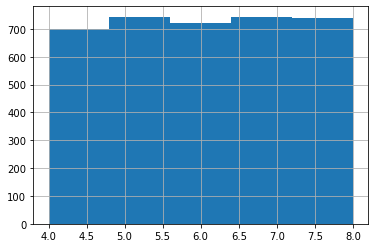

In [17]:
station_data['month'].hist(bins=5)

Данные снимались с апреля по август, скорее всего это связанно с особенностями посевного сезона в данной местности. Количество ежемесяцных экспериментов равномерно.

In [18]:
station_data = station_data.set_index('datetime')

### Температура воздуха [°C]

In [19]:
# проверка корректноси данных
station_data[station_data['air_temp_max']<station_data['air_temp_min']]['air_temp_max'].count()

0

Данные корректны, все максимальные значения меньше минимальных.

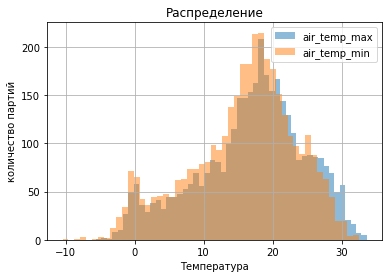

In [20]:
list_param = ['air_temp_max',
              'air_temp_min']
hist_range(station_data, list_param, 'Температура')

На гистограмме видно, что колебания температур невелики, но есть явные выбросы. Температуры, в принципе, соответствуют температурам лета, но есть значения сильных заморосков. Но нам не предоставленны данные, с какой местности были сняты показания, чтобы сравнить их со среднестатистическими, поэтому да данно этапе будем считать их верными.

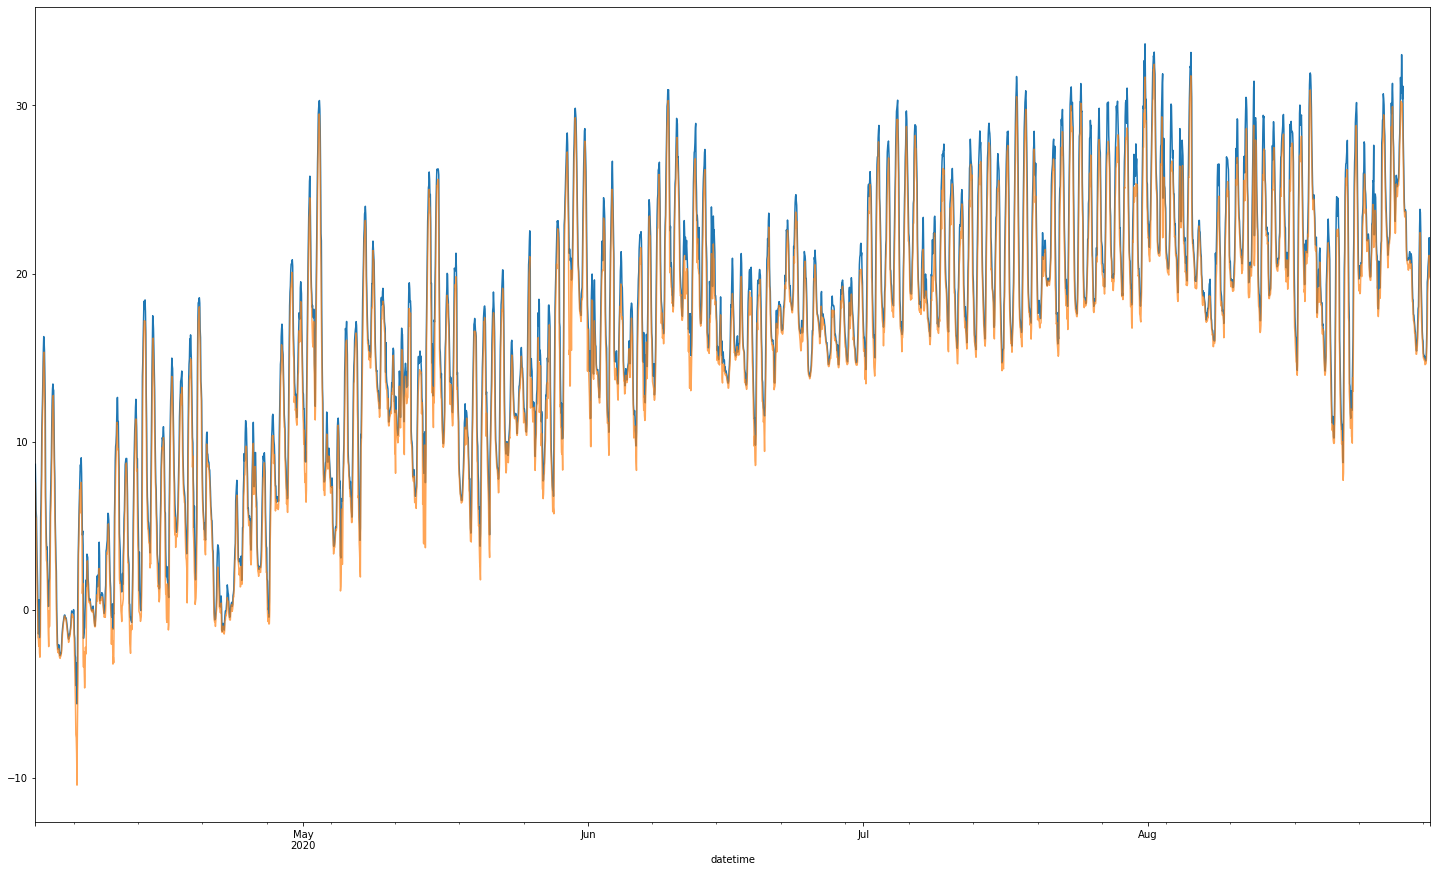

In [21]:
fig, ax = plt.subplots(1, figsize=(25,15))
station_data['air_temp_max'].plot()
station_data['air_temp_min'].plot(alpha=0.7)

На графике колебания температур также видны выбросы, которые могут негативно сказаться на построении модели.

In [22]:
# разница температур
station_data['air_temp_diff'] = station_data.apply(
    lambda x: abs(x['air_temp_max']) + abs(x['air_temp_min']) \
    if x['air_temp_max']>0 and x['air_temp_min']<0 else abs(x['air_temp_max'] - x['air_temp_min']), axis=1)

In [23]:
station_data['air_temp_diff'].describe()

count    3649.000000
mean        1.249986
std         0.957021
min         0.040000
25%         0.570000
50%         1.050000
75%         1.690000
max        10.830000
Name: air_temp_diff, dtype: float64

Есть ярко выраженные выбросы по температуре.

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.040000000000000036 , верхняя граница 4.970000000000001
Процент выбивающихся строк: 1%


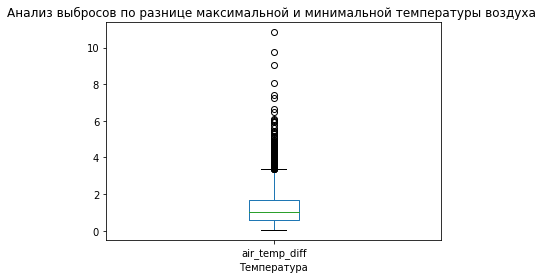

In [24]:
lower_whisker, upper_whisker = box_plot(station_data,
    'air_temp_diff', 'Анализ выбросов по разнице максимальной и минимальной температуры воздуха ', 'Температура')

Так как в наличии нет данных о местности, в которой производились замеры и среднечасовые колебания температур мы установить не можем, будем считать, что все значения разниц, выходящие за границу <i>q3+3*irq</i> уже будут считаться выбросами. К счастью, процент выбросов не так велик.

In [25]:
station_data = station_data.query('(air_temp_diff>=@lower_whisker) & (air_temp_diff<=@upper_whisker)')

In [26]:
# проверка средних значений
station_data[(station_data['air_temp_max'] < station_data['air_temp_mean']) | \
             (station_data['air_temp_min']>station_data['air_temp_mean'])]['air_temp_mean'].count()

0

In [27]:
mean_calc = station_data.apply(
    lambda x: (abs(x['air_temp_max']) - abs(x['air_temp_min']))/2 \
    if x['air_temp_max']>0 and x['air_temp_min']<0 else (x['air_temp_max'] + x['air_temp_min'])/2, axis=1)

In [28]:
mean_calc

datetime
2020-08-31 19:00:00    19.750
2020-08-31 18:00:00    20.180
2020-08-31 17:00:00    20.710
2020-08-31 16:00:00    21.605
2020-08-31 15:00:00    20.655
                        ...  
2020-04-01 23:00:00     3.060
2020-04-01 22:00:00     4.705
2020-04-01 21:00:00     5.685
2020-04-01 20:00:00     6.415
2020-04-01 19:00:00     8.090
Length: 3624, dtype: float64

In [29]:
mean_calc['diff'] = abs(mean_calc) - abs(station_data['air_temp_mean'])
mean_calc['diff'].describe()

count    3624.000000
mean        0.008293
std         0.155885
min        -1.170000
25%        -0.050000
50%         0.005000
75%         0.065000
max         1.275000
dtype: float64

Имеем небольшое отклонение от имеющихся значений среднего и расчетной разницы между максимальным и минимальным значением. Необходимо либо уточнить данные, содержащиеся в столбце по средним температурам. Если это фактическая средняя, необходимо проверить комплекс на корректность расчетов. Также возможны свои алгоритмы расчета средних измерительного комплекса.

Для корректных данных примем корректность начальной и конечной температуры. Заменим среднее.

In [30]:
station_data['air_temp_mean'] = station_data.apply(
    lambda x: (abs(x['air_temp_max']) - abs(x['air_temp_min']))/2 \
    if x['air_temp_max']>0 and x['air_temp_min']<0 else (x['air_temp_max'] + x['air_temp_min'])/2, axis=1)

Для дальнейшего принятия решений проверим данные на мультиколлинеарность.

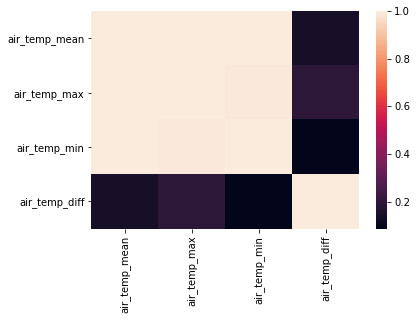

In [31]:
sns.heatmap(station_data[['air_temp_mean',
                          'air_temp_max',              
                          'air_temp_min',
                          'air_temp_diff']].corr())

Мы видим ярковыраженную мультиколлинеарность факторов. Пока оставим эти факторы для создания первичной модели, но в последствии учтем корреляцию признаков.

### Точка росы [°C]

In [32]:
# проверка корректноси данных
(station_data['dew_point_mean']-station_data['dew_point_min']).describe()

count    3624.000000
mean        0.604332
std         0.569319
min         0.000000
25%         0.200000
50%         0.400000
75%         0.800000
max         6.000000
dtype: float64

Отрицательных значений нет, значит все минимальные значения меньше средних, это корректно.

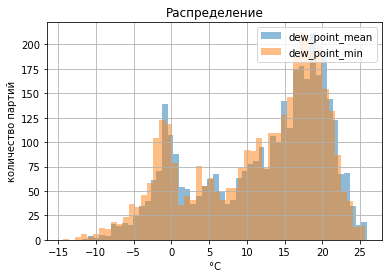

In [33]:
list_param = ['dew_point_mean',
              'dew_point_min']
hist_range(station_data, list_param, '°C')

Распределение с левосторонней ассиметрией.

Расчет крайних значений при q3+3*irq:
Нижняя граница -11.8 , верхняя граница 25.9
Процент выбивающихся строк: 0%


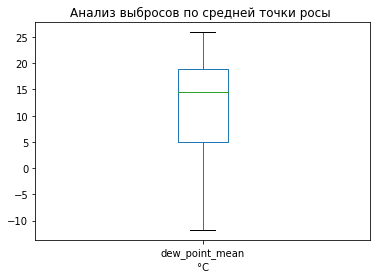

In [34]:
# проверим средние на выбросы
lower_whisker, upper_whisker = box_plot(station_data,
    'dew_point_mean', 'Анализ выбросов по средней точки росы ', '°C')

Явных выбросов по средним нет.

Расчет крайних значений при q3+3*irq:
Нижняя граница -14.4 , верхняя граница 25.7
Процент выбивающихся строк: 0%


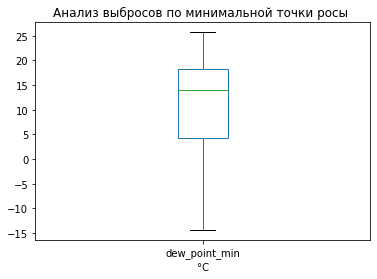

In [35]:
# проверим минимальные на выбросы
lower_whisker, upper_whisker = box_plot(station_data,
    'dew_point_min', 'Анализ выбросов по минимальной точки росы ', '°C')

Выбросов нет. Создадим расчетные столбцы максимальных значений и колебаний точки росы и проверим на корреляцию.

In [36]:
# максимальная точка росы
station_data['dew_point_max'] = station_data['dew_point_mean']*2 - station_data['dew_point_min']

In [37]:
# разница точка росы
station_data['dew_point_diff'] =  station_data.apply(
    lambda x: abs(x['dew_point_max']) + abs(x['dew_point_min']) \
    if x['dew_point_max']>0 and x['dew_point_min']<0 else abs(x['dew_point_max'] - x['dew_point_min']), axis=1)

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.0 , верхняя граница 5.199999999999999
Процент выбивающихся строк: 1%


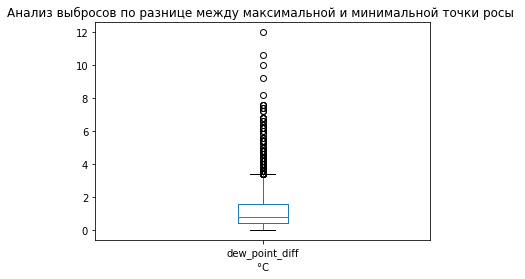

In [38]:
# проверим выбросы по разнице между максимальной и минимальной
lower_whisker, upper_whisker = box_plot(station_data,
    'dew_point_diff', 'Анализ выбросов по разнице между максимальной и минимальной точки росы ', '°C')

Хоть по средней и минимальной точки росы выбросов не было, есть выбросы по разнице минимального и максимального. Лучше удалить данные значения.

In [39]:
station_data = station_data.query('(dew_point_diff>=@lower_whisker) & (dew_point_diff<=@upper_whisker)')

Проверим данные на взаимную корреляцию.

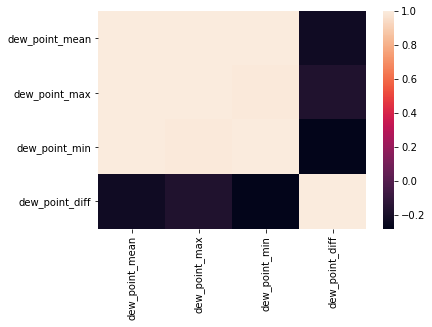

In [40]:
sns.heatmap(station_data[['dew_point_mean',
                          'dew_point_max',              
                          'dew_point_min',
                          'dew_point_diff']].corr())

Ярко выраженная корреляция признаков. Учтем при моделировании.

### Солнечная радиация [W/m2]

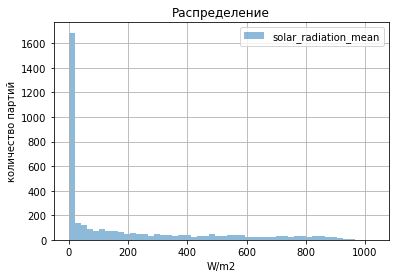

In [41]:
list_param = ['solar_radiation_mean']
hist_range(station_data, list_param, 'W/m2')

Огромный всплеск нулевых значений и странные значения в Вт по радиации для летних месяцев, так как по открытым источникам  средняя дневная сумма солнечной радиации в июне, кВтч/м²[3], например:

- Мурманск 5,14
- Архангельск   5,51
- Якутск 6,19
- Санкт-Петербург 5,78
- Москва 5,56
- Новосибирск 5,48

Максимальная радиация 1 кВтч/м² и это в летние месяцы, показания снимались либо в южном полушарии в южных точках, когда у них зима, но тогда в эти периоды там расти нечему.

В данном случае значение данного столбца вызывают сильные сомнения и для построения модели не подходят, следовательно, неоходимо удалить данный признак. А также необходимо довести до сведения инженеров по обслуживанию комплекса данные о том, что снимаются неверные показатели.

In [42]:
station_data = station_data.drop('solar_radiation_mean', axis=1)

### Дефицит давления пара [kPa]

In [43]:
# проверка корректноси данных
(station_data['VPD_mean']-station_data['VPD_min']).describe()

count    3581.000000
mean        0.075066
std         0.085263
min         0.000000
25%         0.000000
50%         0.050000
75%         0.120000
max         0.660000
dtype: float64

Корректно.

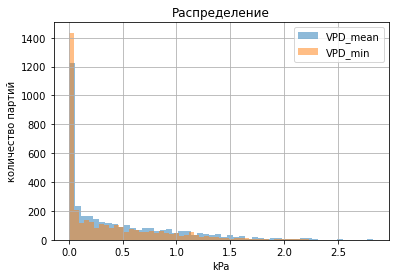

In [44]:
list_param = ['VPD_mean',
              'VPD_min']
hist_range(station_data, list_param, 'kPa')

Дефицит давления пара , или VPD , - это разница (дефицит) между количеством влаги в воздухе и тем, сколько влаги воздух может удерживать, когда он насыщен. Когда воздух становится насыщенным, вода конденсируется с образованием облаков, росы или водяных пленок на листьях. Именно в этом последнем случае УИ играет важную роль в регулировании тепличного хозяйства . Если на листе растения образуется водная пленка, он становится более подверженным гниению. С другой стороны, по мере увеличения VPD растению требуется больше воды из корней. В случае черенкования растение может засохнуть и погибнуть. По этой причине идеальный диапазон VPD в теплице составляет от 0,45  кПа. до 1,25 кПа, в идеале около 0,85 кПа. Как правило, большинство растений хорошо растут при VPD от 0,8 до 0,95 кПа.

Данные по распределениям не выглядят сильно неккоректными, но необходимо проверить их на выбросы.

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.0 , верхняя граница 2.83
Процент выбивающихся строк: 0%


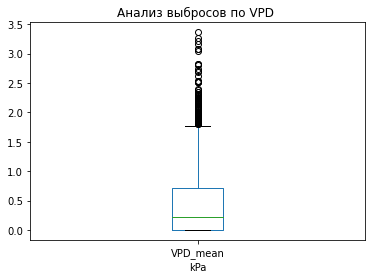

In [45]:
# проверим средние на выбросы
lower_whisker, upper_whisker = box_plot(station_data,
    'VPD_mean', 'Анализ выбросов по VPD ', 'kPa')

Есть выбросы.

In [46]:
# удаление выбросов
station_data = station_data.query('(VPD_mean>=@lower_whisker) & (VPD_mean<=@upper_whisker)')

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.0 , верхняя граница 2.27
Процент выбивающихся строк: 0%


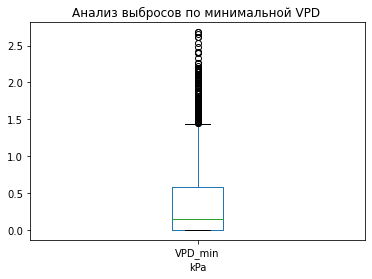

In [47]:
# проверим минимальные на выбросы
lower_whisker, upper_whisker = box_plot(station_data,
    'VPD_min', 'Анализ выбросов по минимальной VPD ', 'kPa')

In [48]:
# удаление выбросов
station_data = station_data.query('(VPD_min>=@lower_whisker) & (VPD_min<=@upper_whisker)')

Рассчитаем максимальное значение и изменения VPD.

In [49]:
# максимальное значение
station_data['VPD_max'] = station_data['VPD_mean']*2 - station_data['VPD_min']

In [50]:
# разница 
station_data['VPD_diff'] =  station_data['VPD_max'] - station_data['VPD_min']

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.0 , верхняя граница 0.8800000000000006
Процент выбивающихся строк: 0%


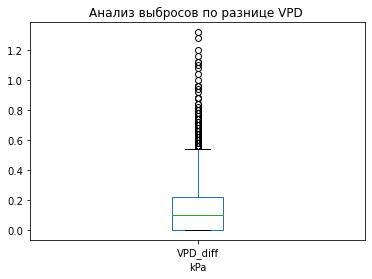

In [51]:
# проверим разницу на выбросы
lower_whisker, upper_whisker = box_plot(station_data,
    'VPD_diff', 'Анализ выбросов по разнице VPD ', 'kPa')

Выбросы есть, но их немного.

In [52]:
# удаление выбросов
station_data = station_data.query('(VPD_diff>=@lower_whisker) & (VPD_diff<=@upper_whisker)')

### Влажность воздуха  [%]

In [53]:
station_data[['air_humidity_mean',
             'air_humidity_max',
             'air_humidity_min']].describe()

,air_humidity_mean,air_humidity_max,air_humidity_min
count,3548.000000,3548.000000,3548.000000
mean,80.310051,83.306339,77.204946
std,20.702186,19.579755,21.812362
min,18.140000,19.530000,16.010000
25%,68.207500,72.745000,63.120000
50%,86.330000,90.365000,81.700000
75%,99.930000,99.970000,99.562500
max,100.000000,100.000000,100.000000


Влажность корректная, нет отрицательных значений и больше 100%.

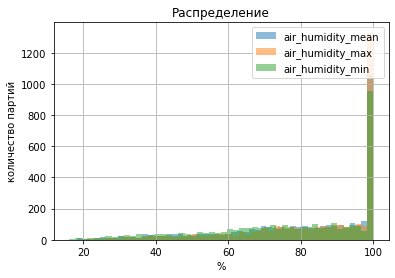

In [54]:
list_param = ['air_humidity_mean',
             'air_humidity_max',
             'air_humidity_min']
hist_range(station_data, list_param, '%')

Регион с достаточно высокой влажностью, так как распределение увеличивается к 100% и много значений с максимальной влажностью. 

In [55]:
((station_data['air_humidity_max'] + station_data['air_humidity_min'])/2 - station_data['air_humidity_mean']).describe()

count    3548.000000
mean       -0.054408
std         1.009820
min        -9.045000
25%        -0.335000
50%         0.000000
75%         0.215000
max         7.340000
dtype: float64

Опять измеренные средние не совпадают с расчетными. Нужно обратить внимание нам настройку станции. Берем за основу на данном этапе, что корректны минимальные и максимальные.

In [56]:
# расчет среднего
station_data['air_humidity_mean'] = (station_data['air_humidity_max'] + station_data['air_humidity_min'])/2

Расчет крайних значений при q3+3*irq:
Нижняя граница 16.01 , верхняя граница 100.0
Процент выбивающихся строк: 0%


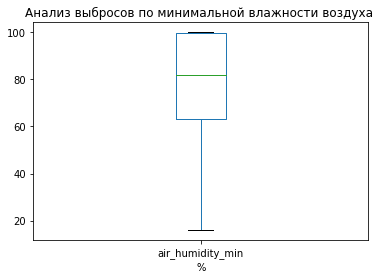

In [57]:
# выбросы по минимальному
lower_whisker, upper_whisker = box_plot(station_data,
    'air_humidity_min', 'Анализ выбросов по минимальной влажности воздуха ', '%')

Расчет крайних значений при q3+3*irq:
Нижняя граница 19.53 , верхняя граница 100.0
Процент выбивающихся строк: 0%


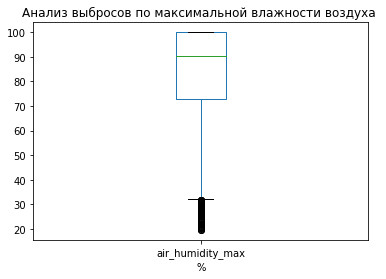

In [58]:
# выбросы по максимальному
lower_whisker, upper_whisker = box_plot(station_data,
    'air_humidity_max', 'Анализ выбросов по максимальной влажности воздуха ', '%')

По максимальной есть выбросы.

In [59]:
# удаление выбросов
station_data = station_data.query('(air_humidity_max>=@lower_whisker) & (air_humidity_max<=@upper_whisker)')

In [60]:
# расчет изменений влажности
station_data['air_humidity_diff'] = station_data['air_humidity_max'] - station_data['air_humidity_min']

In [61]:
station_data['air_humidity_diff'].describe()

count    3548.000000
mean        6.101392
std         5.822872
min         0.000000
25%         0.437500
50%         5.340000
75%         9.040000
max        42.840000
Name: air_humidity_diff, dtype: float64

Отрицательной разницы нет, все максимальные больше минимальных.

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.0 , верхняя граница 33.709999999999994
Процент выбивающихся строк: 0%


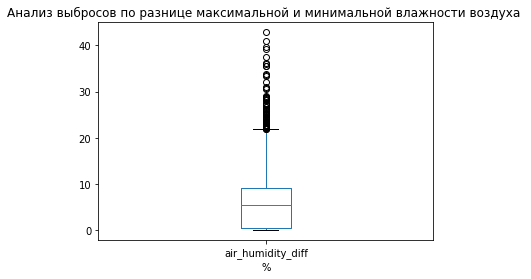

In [62]:
# выбросы по максимальному
lower_whisker, upper_whisker = box_plot(station_data,
    'air_humidity_diff', 'Анализ выбросов по разнице максимальной и минимальной влажности воздуха ', '%')

In [63]:
# удаление выбросов
station_data = station_data.query('(air_humidity_diff>=@lower_whisker) & (air_humidity_diff<=@upper_whisker)')

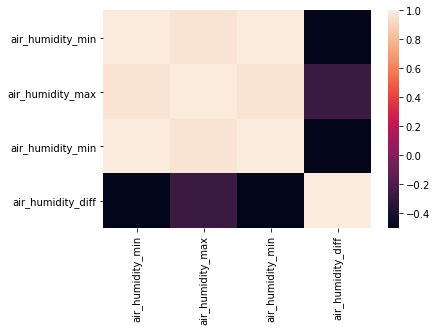

In [64]:
sns.heatmap(station_data[['air_humidity_min',
                          'air_humidity_max',              
                          'air_humidity_min',
                          'air_humidity_diff']].corr())

Учтем корреляцию при построении модели.

### Осадки [mm]

In [65]:
station_data['precipitation'].describe()

count    3539.000000
mean        0.108675
std         0.530645
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: precipitation, dtype: float64

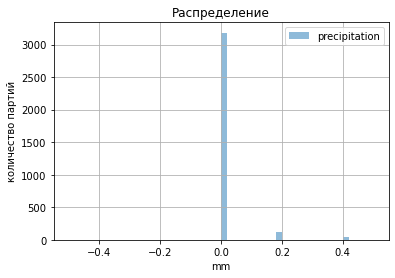

In [66]:
list_param = ['precipitation']
hist_range(station_data, list_param, 'mm')

Либо замеры проводились в пустыне, но рядом с водоемом, либо данные некорректны. Как ранее изучалось, влажность воздуха достаточно высокая, но осадков почти нет. Разъяснений по региону у нас нет, поэтому пока оставим данный столбец, удалив все выбросы.

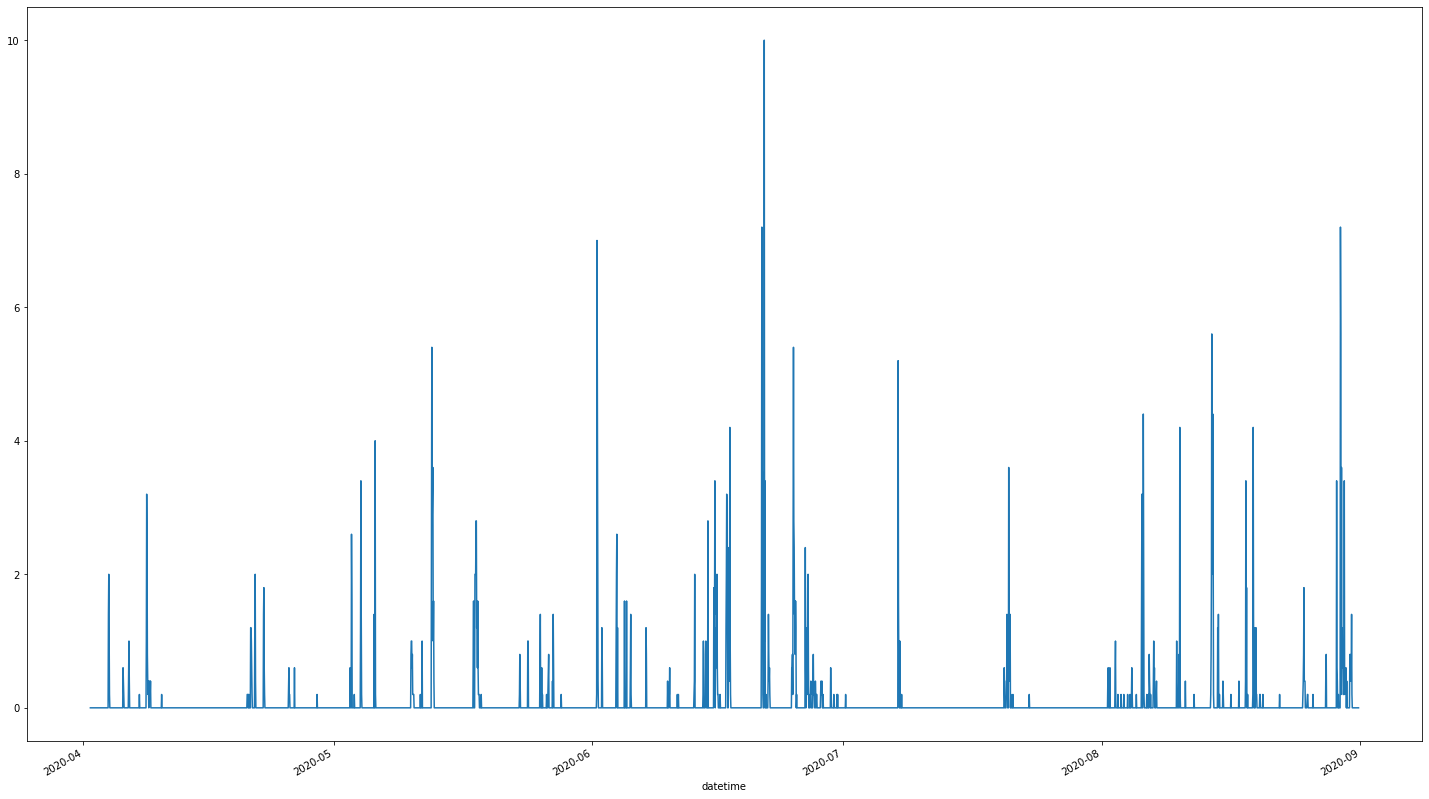

In [67]:
fig, ax = plt.subplots(1, figsize=(25,15))
station_data['precipitation'].plot();

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.0 , верхняя граница 0.0
Процент выбивающихся строк: 10%


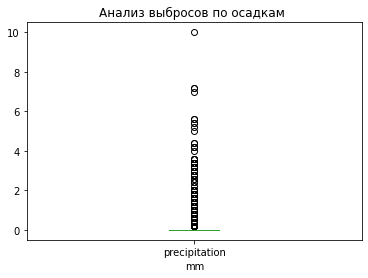

In [68]:
# выбросы 
lower_whisker, upper_whisker = box_plot(station_data,
    'precipitation', 'Анализ выбросов по осадкам ', 'mm')

В нашем случае идет сильная разбалансировка по значениям осадков, очень мало значений об осадках в течении измеряемого периода. Местность засушливая с высокой влажностью. В данном случае нецелесообразно удалять выбросы, так как они имеют большую ценность для модели.

### Влажность листа [минимум]

In [69]:
station_data['leaf_humidity_min'].describe()

count    3539.000000
mean       14.522464
std        24.926647
min         0.000000
25%         0.000000
50%         0.000000
75%        25.000000
max        75.000000
Name: leaf_humidity_min, dtype: float64

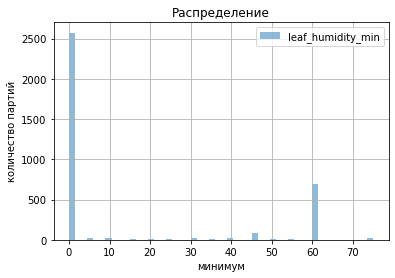

In [70]:
list_param = ['leaf_humidity_min']
hist_range(station_data, list_param, 'минимум')

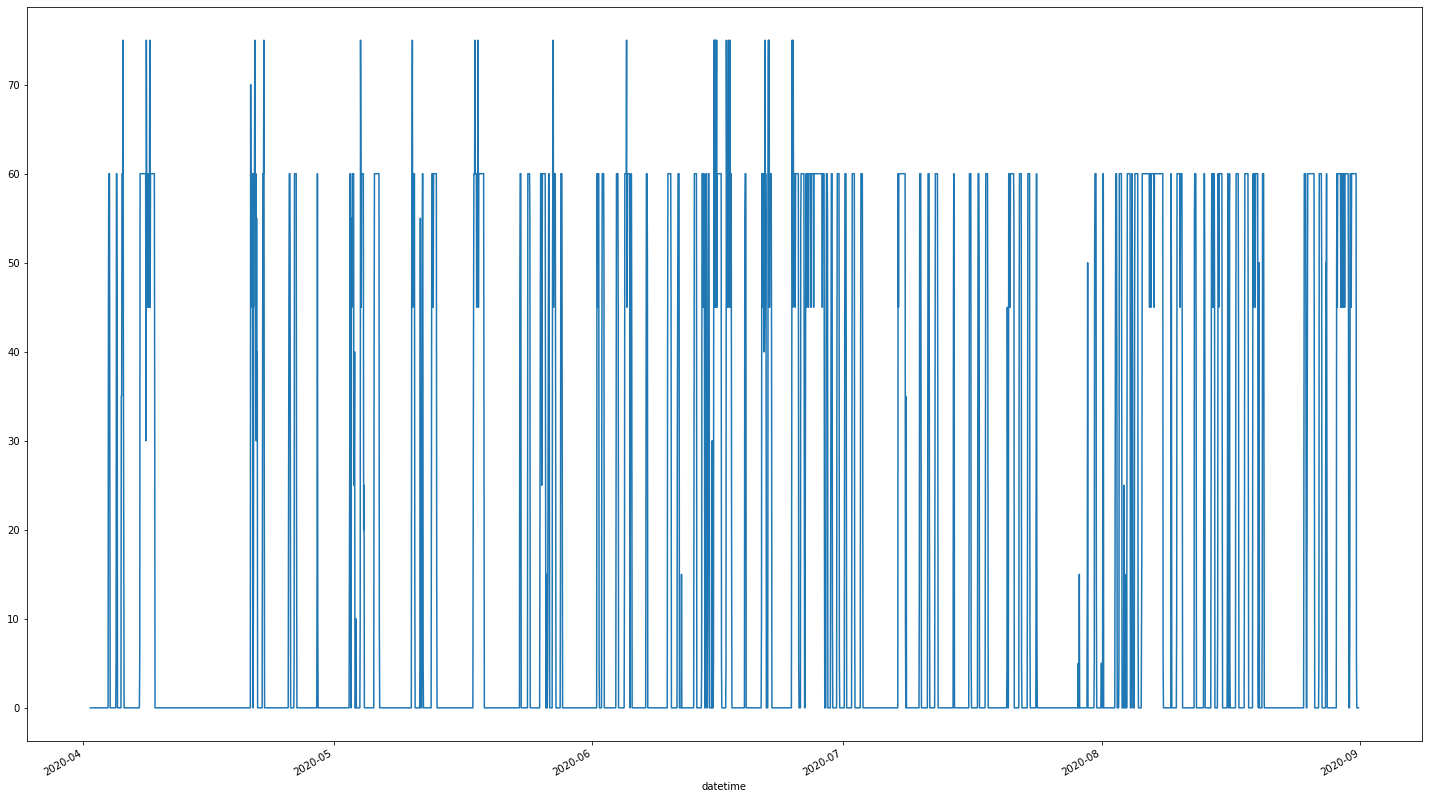

In [71]:
fig, ax = plt.subplots(1, figsize=(25,15))
station_data['leaf_humidity_min'].plot();

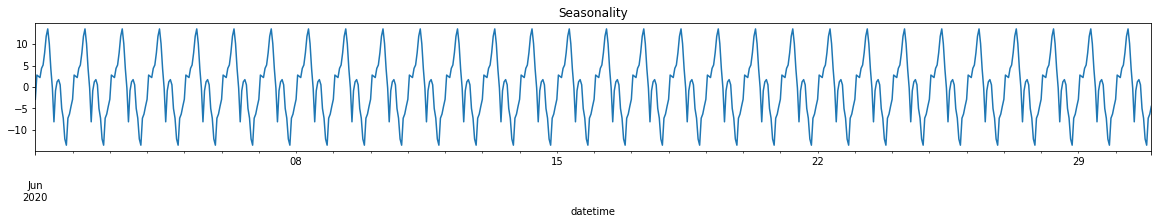

In [72]:
resample = station_data['leaf_humidity_min'].resample('1H').sum()
decomposed = seasonal_decompose(resample['2020-06-01':'2020-06-30']) 

plt.figure(figsize=(20, 8))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality');

Ярковыраженные суточные колебания влажности, яркая зависимость от часа. Введем дополнительный параметр, час в сутках.

In [73]:
station_data['hour'] = station_data.index.hour

Расчет крайних значений при q3+3*irq:
Нижняя граница 0 , верхняя граница 75
Процент выбивающихся строк: 0%


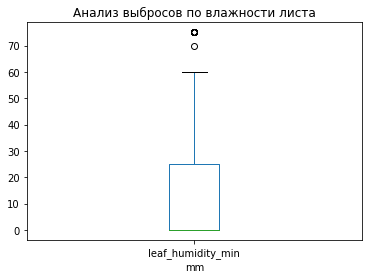

In [74]:
# выбросы 
lower_whisker, upper_whisker = box_plot(station_data,
    'leaf_humidity_min', 'Анализ выбросов по влажности листа', 'mm')

Выбросов явных нет. Это целевой признак, поэтому пренебрегать качеством данных по нему мы не можем.

### Скорость ветра [m/s]

In [75]:
# проверка корректноси данных
(station_data['wind_speed_max']-station_data['wind_speed_mean']).describe()

count    3539.000000
mean        0.519780
std         0.334638
min         0.000000
25%         0.300000
50%         0.500000
75%         0.700000
max         3.400000
dtype: float64

In [76]:
# проверка корректноси данных
station_data[['wind_speed_max', 'wind_speed_mean']].describe()

,wind_speed_max,wind_speed_mean
count,3539.000000,3539.000000
mean,1.748290,1.228511
std,1.330972,1.140160
min,0.000000,0.000000
25%,0.800000,0.300000
50%,1.400000,0.900000
75%,2.500000,1.800000
max,9.100000,7.700000


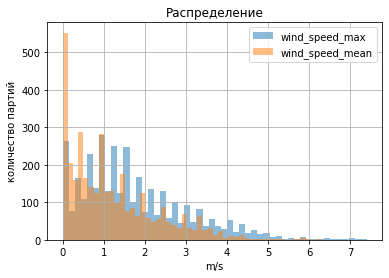

In [77]:
list_param = ['wind_speed_max', 'wind_speed_mean']
hist_range(station_data, list_param, 'm/s')

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.0 , верхняя граница 6.3
Процент выбивающихся строк: 0%


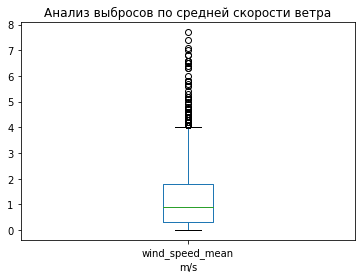

In [78]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'wind_speed_mean', 'Анализ выбросов по средней скорости ветра', 'm/s')

In [79]:
# удаление выбросов
station_data = station_data.query('(wind_speed_mean>=@lower_whisker) & (wind_speed_mean<=@upper_whisker)')

In [80]:
# расчет минимальной скорости ветра
station_data['wind_speed_min'] = station_data['wind_speed_mean']*2 - station_data['wind_speed_max']

Расчет крайних значений при q3+3*irq:
Нижняя граница -1.5 , верхняя граница 4.799999999999999
Процент выбивающихся строк: 0%


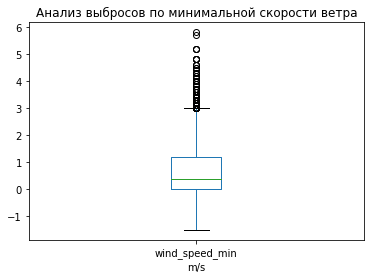

In [81]:
# выбросы по минимальной
lower_whisker, upper_whisker = box_plot(station_data,
    'wind_speed_min', 'Анализ выбросов по минимальной скорости ветра', 'm/s')

Максимальные и средние значения не соответствуют друг другу. Получает отрицательную минимальную скорость ветра, что не может быть правдой. Требуются уточнение данных и проверка оборудования. За основу берем среднюю.

In [82]:
station_data = station_data.drop(['wind_speed_max', 'wind_speed_min'], axis=1)

### Влажность почвы [%]

In [83]:
# проверка корректноси данных
station_data['soil_humidity_mean'].describe()

count    3527.000000
mean       37.548645
std         5.039701
min        29.400000
25%        31.840000
50%        39.010000
75%        41.100000
max        47.170000
Name: soil_humidity_mean, dtype: float64

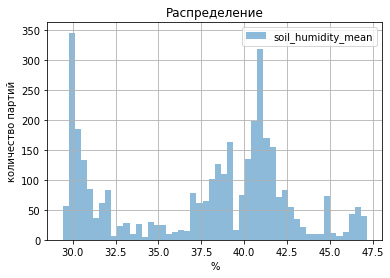

In [84]:
list_param = ['soil_humidity_mean']
hist_range(station_data, list_param, '%')

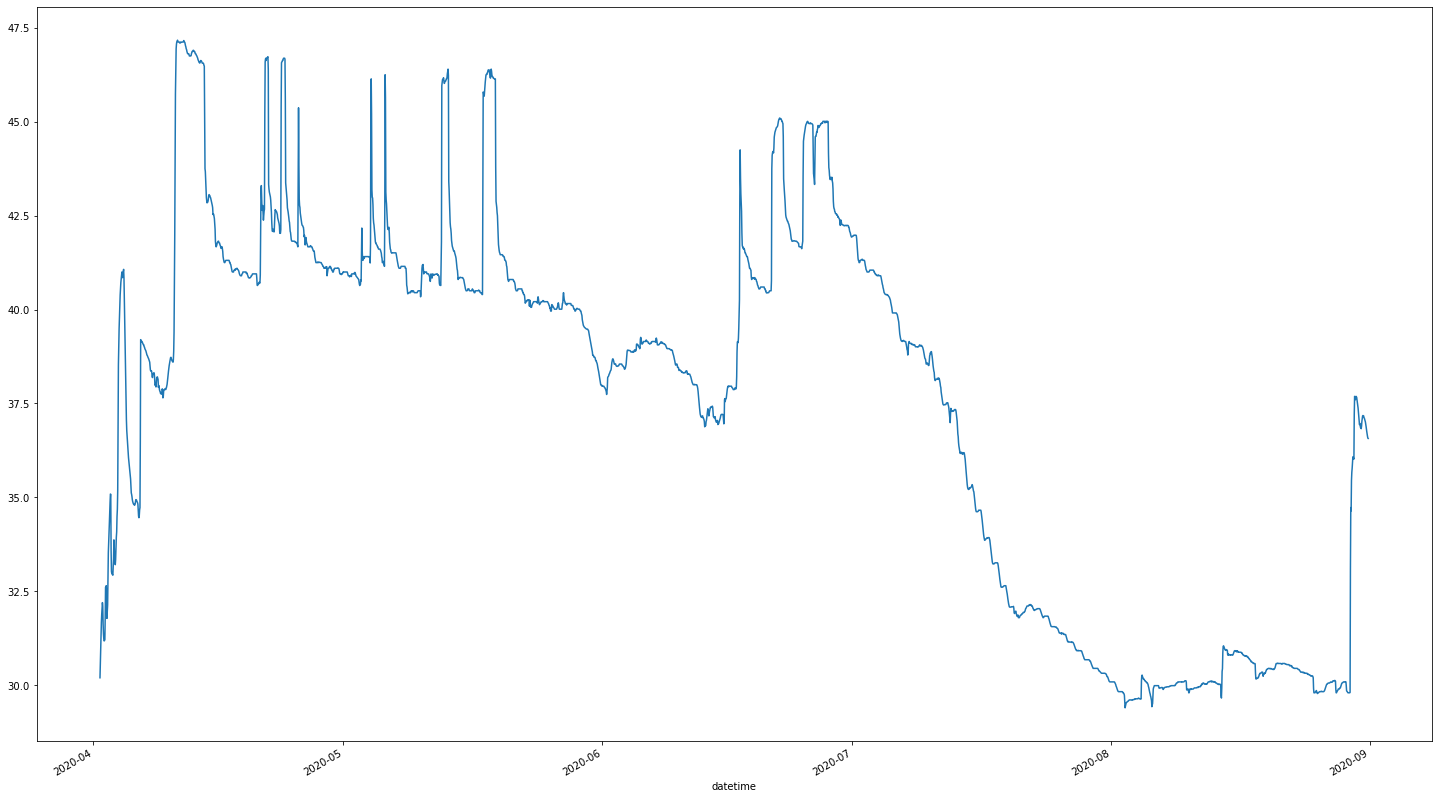

In [85]:
fig, ax = plt.subplots(1, figsize=(25,15))
station_data['soil_humidity_mean'].plot()

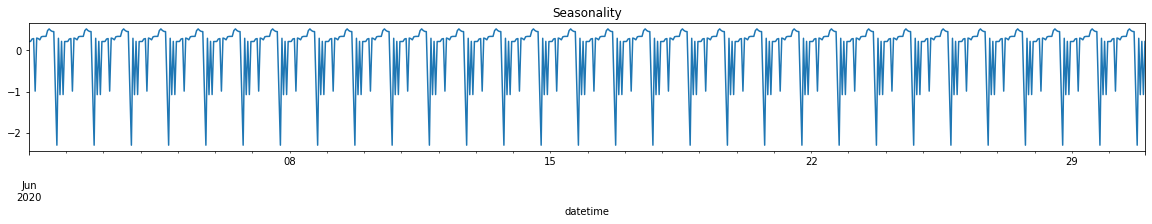

In [86]:
resample = station_data['soil_humidity_mean'].resample('1H').sum()
decomposed = seasonal_decompose(resample['2020-06-01':'2020-06-30']) 

plt.figure(figsize=(20, 8))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality');

In [87]:
station_data[['soil_humidity_mean', 'precipitation']].corr()

,soil_humidity_mean,precipitation
soil_humidity_mean,1.000000,0.027619
precipitation,0.027619,1.000000


Получаются интересные данные. По идее влажность почвы напрямую зависит от осадков, но в данном случае мы имеем дело с системой искусственного полива, что хорошо видно по ежедневным изменениям влажности, основная влажность приходится на конец дня. Признак часа в сутках мы уже ввели. Так же есть явная зависимость влажности почвы от месяца. Но использование данного признака может привести к неправильному моделированию, так как мы имеем данные всего по нескольким месяца.

Расчет крайних значений при q3+3*irq:
Нижняя граница 29.4 , верхняя граница 47.17
Процент выбивающихся строк: 0%


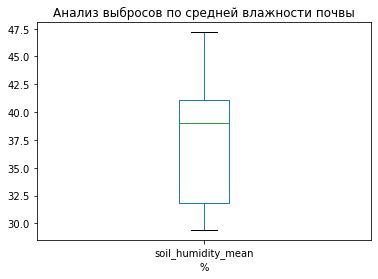

In [88]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'soil_humidity_mean', 'Анализ выбросов по средней влажности почвы', '%')

Выбросы отсутствуют.

### Температура почвы [°C]

In [89]:
station_data[['soil_temp_mean',
              'soil_temp_max',
              'soil_temp_min']].describe()

,soil_temp_mean,soil_temp_max,soil_temp_min
count,3527.000000,3527.000000,3527.000000
mean,13.367168,14.889141,11.987780
std,6.454709,6.498798,6.478524
min,-0.200000,0.200000,-2.200000
25%,9.900000,11.700000,8.700000
50%,14.400000,17.200000,13.100000
75%,18.600000,20.000000,17.200000
max,22.100000,23.700000,21.200000


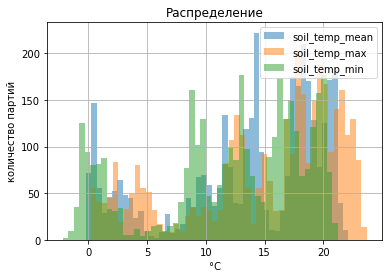

In [90]:
list_param = ['soil_temp_mean',
              'soil_temp_max',
              'soil_temp_min']
hist_range(station_data, list_param, '°C')

Разброс значений минимального и максимального заметен. Нужно проверить на корректность каждое значение.

In [91]:
(station_data['soil_temp_max'] - station_data['soil_temp_min']).describe()

count    3527.000000
mean        2.901361
std         1.074435
min         0.100000
25%         2.300000
50%         3.000000
75%         3.800000
max         5.100000
dtype: float64

Все минимальные меньше максимальных.

In [92]:
((station_data['soil_temp_max'] + station_data['soil_temp_min'])/2 - station_data['soil_temp_mean']).describe()

count    3527.000000
mean        0.071293
std         0.603642
min        -1.600000
25%        -0.350000
50%         0.100000
75%         0.500000
max         1.600000
dtype: float64

Опять отклонения средних замеров, необходимо провести настройку оборудования.

In [93]:
# замена среднего расчетным
station_data['soil_temp_mean'] = (station_data['soil_temp_max'] + station_data['air_humidity_min'])/2

Расчет крайних значений при q3+3*irq:
Нижняя граница 9.285 , верхняя граница 61.845
Процент выбивающихся строк: 0%


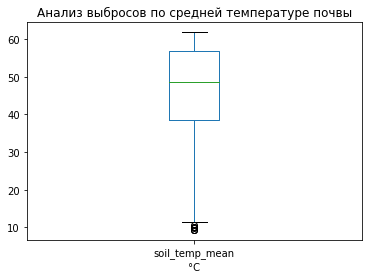

In [94]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'soil_temp_mean', 'Анализ выбросов по средней температуре почвы', '°C')

In [95]:
# удаление выбросов
station_data = station_data.query('(soil_temp_mean>=@lower_whisker) & (soil_temp_mean<=@upper_whisker)')

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.2 , верхняя граница 23.7
Процент выбивающихся строк: 0%


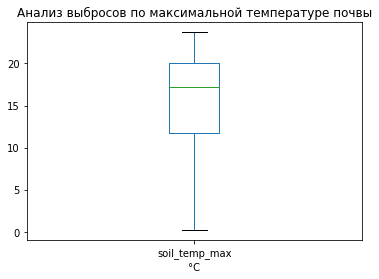

In [96]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'soil_temp_max', 'Анализ выбросов по максимальной температуре почвы', '°C')

Расчет крайних значений при q3+3*irq:
Нижняя граница -2.2 , верхняя граница 21.2
Процент выбивающихся строк: 0%


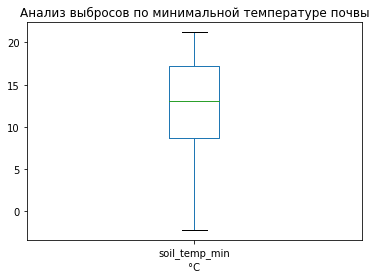

In [97]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'soil_temp_min', 'Анализ выбросов по минимальной температуре почвы', '°C')

In [98]:
# расчет изменений влажности
station_data['soil_temp_diff'] = station_data['soil_temp_max'] - station_data['soil_temp_min']

In [99]:
station_data['soil_temp_diff'].describe()

count    3527.000000
mean        2.901361
std         1.074435
min         0.100000
25%         2.300000
50%         3.000000
75%         3.800000
max         5.100000
Name: soil_temp_diff, dtype: float64

Расчет крайних значений при q3+3*irq:
Нижняя граница 0.09999999999999998 , верхняя граница 5.100000000000001
Процент выбивающихся строк: 0%


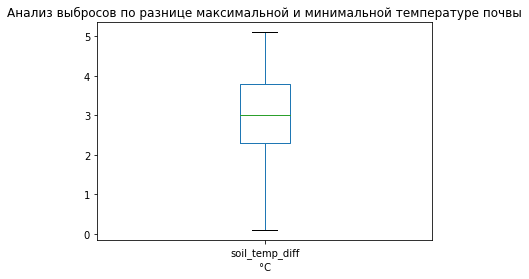

In [100]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'soil_temp_diff', 'Анализ выбросов по разнице максимальной и минимальной температуре почвы', '°C')

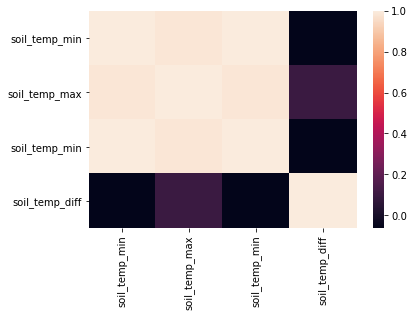

In [101]:
sns.heatmap(station_data[['soil_temp_min',
                          'soil_temp_max',              
                          'soil_temp_min',
                          'soil_temp_diff']].corr())

Есть корреляция признаков, необходимо это учитывать.

### Эталонная эвапотранспирация ET0 [mm]

Есть пропуски в данном столбце. Эталонная эвапотранспирация расчитывается методом Пенмана-Монтейта. К сожалению, в формуле участвует солнечная радиация,в адекватности значений которой можно сомневаться, поэтому использование данного параметра так же пока не имеет смысла, так как адекватных расчетных данных мы получить не сможем. 

In [102]:
station_data = station_data.drop('ETo', axis=1)

### Солнечная панель [mV], АКБ [mV], АКБ2 [mV]

Влияние состояний самой метеостанции на результаты замеров. Теоретически, нехватка мощности, из-за малого заряда батарей могут влиять на параметры замеров.

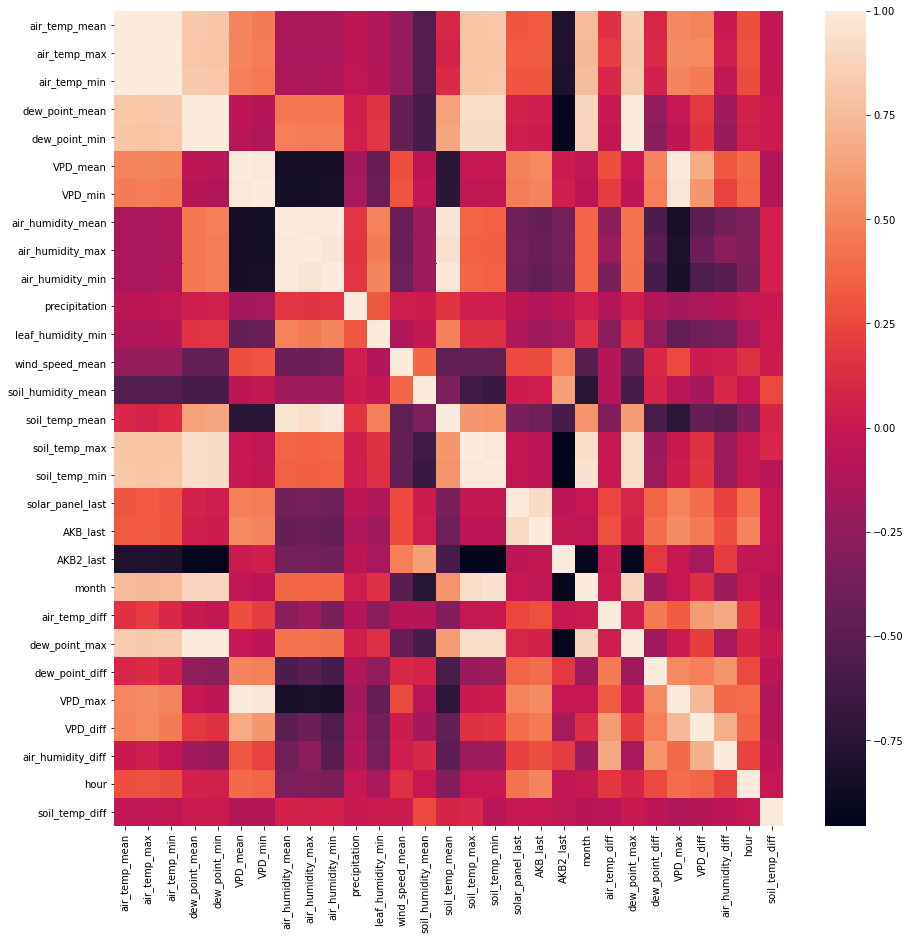

In [103]:
fig, ax = plt.subplots(1, figsize=(15,15))
sns.heatmap(station_data.corr());

Зависимость на результаты замеров не ощутимые, но есть. Необходимо учитывать данные факторы.

Расчет крайних значений при q3+3*irq:
Нижняя граница 0 , верхняя граница 10458
Процент выбивающихся строк: 0%


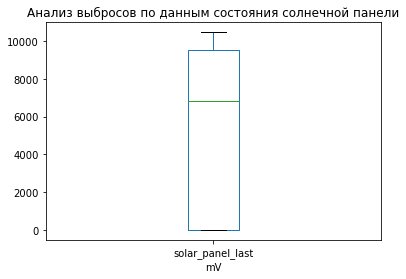

In [104]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'solar_panel_last', 'Анализ выбросов по данным состояния солнечной панели', 'mV')

Расчет крайних значений при q3+3*irq:
Нижняя граница 6383 , верхняя граница 6853
Процент выбивающихся строк: 0%


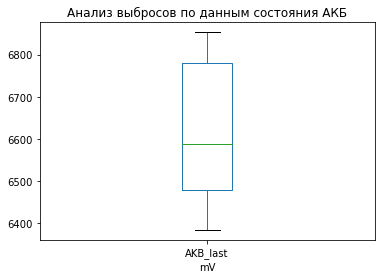

In [105]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'AKB_last', 'Анализ выбросов по данным состояния АКБ', 'mV')

Расчет крайних значений при q3+3*irq:
Нижняя граница 3634 , верхняя граница 3725
Процент выбивающихся строк: 0%


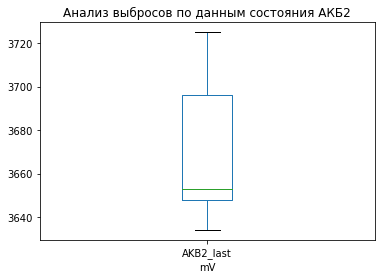

In [106]:
# выбросы по среднему
lower_whisker, upper_whisker = box_plot(station_data,
    'AKB2_last', 'Анализ выбросов по данным состояния АКБ2', 'mV')

Использование временного индекса в дальнейшем не имеет смысла.

In [107]:
station_data = station_data.reset_index().drop('datetime', axis=1)

### Вывод

In [108]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3527 entries, 0 to 3526
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp_mean       3527 non-null   float64
 1   air_temp_max        3527 non-null   float64
 2   air_temp_min        3527 non-null   float64
 3   dew_point_mean      3527 non-null   float64
 4   dew_point_min       3527 non-null   float64
 5   VPD_mean            3527 non-null   float64
 6   VPD_min             3527 non-null   float64
 7   air_humidity_mean   3527 non-null   float64
 8   air_humidity_max    3527 non-null   float64
 9   air_humidity_min    3527 non-null   float64
 10  precipitation       3527 non-null   float64
 11  leaf_humidity_min   3527 non-null   int64  
 12  wind_speed_mean     3527 non-null   float64
 13  soil_humidity_mean  3527 non-null   float64
 14  soil_temp_mean      3527 non-null   float64
 15  soil_temp_max       3527 non-null   float64
 16  soil_t

По данным анализа были выявлены некорректные данные, которые нуждаются в уточнении. Также были выявлены ошибки в работе оборудования, что необходимо передать инженерам, для проверки и настройки комплекса.

Также при моделировании стоит учитывать то, что в исследовании, судя по данным, участвовал только один комплекс. Данных с этого комплекса не хватит для корректной и полной модели предсказания влажности листа, так как отсутствует полная статистика, собранная из разных комплексов, установленных в разных местах.  Но для составления прототипа модели этих данных на данном этапе хватит.

## Создание моделей

In [109]:
def features_target(data, target_column):
    """Функция деления данных на объекты и целевой признак"""
    features = data.drop([target_column], axis=1)
    target = data[target_column]
    print('Объекты:', features.shape)
    print('Целевой признак:', target.shape)
    return features, target

In [110]:
#Создание обучающей выборки (75% данных)
train, test = train_test_split(station_data, test_size=0.25, random_state=12345)

In [111]:
#Разбиение на признаки и целевой признак
print('Обучающая выборка')
features_train, target_train=features_target(train, 'leaf_humidity_min')
print('Тестовая выборка')
features_test, target_test=features_target(test, 'leaf_humidity_min')

Обучающая выборка
Объекты: (2645, 28)
Целевой признак: (2645,)
Тестовая выборка
Объекты: (882, 28)
Целевой признак: (882,)


Для начала составим модель без учета корреляции признаков и их важности. Для оценки исмользуем MAE, среднюю абсолютную ошибку.

###  Модель решающего дерева

In [112]:
def DecisionTree(features, target):
    """Функция построения моделей решающего дерева"""
    #создаем функцию оценки, оценка будет по поиску минимуму
    mae = make_scorer(mean_absolute_error, greater_is_better=False)
    
    model = DecisionTreeRegressor(random_state=12345)
    #параметры для перебора
    param ={
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
          'min_samples_leaf' : [1, 2]
           }
    #Поиск наилучших параметров
    GSCV = GridSearchCV(model, param, cv = 5, scoring =  mae, verbose=True)
    GSCV.fit(features, target)
    print('----Наилучшая модель----')
    print(GSCV.best_estimator_)               
    print('MAE = {:.2f}'.format(mean_absolute_error(target, GSCV.predict(features))))   
    return GSCV

In [113]:
model_DecisionTree = DecisionTree(features_train, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
----Наилучшая модель----
DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, random_state=12345)
MAE = 2.75


In [114]:
# модель решающего дерева
predict_DecisionTree = model_DecisionTree.predict(features_test)
mae = mean_absolute_error(target_test, predict_DecisionTree)
print('---Тестовая выборка---')
print('MAE = {:.2f}'. format(mae))

---Тестовая выборка---
MAE = 8.82


### Модель случайного леса

In [115]:
def RandomForest(features, target):
    """Функция построения моделей случайного леса"""
    #создаем функцию оценки, оценка будет по поиску минимуму
    mae = make_scorer(mean_absolute_error, greater_is_better=False)
    
    model = RandomForestRegressor(random_state=12345)
    #параметры для перебора
    param ={
          'max_depth': [2, 4, 6, 8, 10], 
          'n_estimators' : range(10, 100, 10),
           }
    #Поиск наилучших параметров
    GSCV = GridSearchCV(model, param, cv = 3, scoring =  mae, verbose=2)
    GSCV.fit(features, target)
    print('----Наилучшая модель----')
    print(GSCV.best_estimator_)
    print('MAE = {:.2f}'.format(mean_absolute_error(target, GSCV.predict(features))))   
    return GSCV

In [116]:
model_RandomForest = RandomForest(features_train, target_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=40; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=40; total time=   0.1s
[CV] END .......................max_depth=2, n_

[CV] END .......................max_depth=8, n_estimators=70; total time=   1.0s
[CV] END .......................max_depth=8, n_estimators=80; total time=   1.2s
[CV] END .......................max_depth=8, n_estimators=80; total time=   1.1s
[CV] END .......................max_depth=8, n_estimators=80; total time=   1.2s
[CV] END .......................max_depth=8, n_estimators=90; total time=   1.4s
[CV] END .......................max_depth=8, n_estimators=90; total time=   1.3s
[CV] END .......................max_depth=8, n_estimators=90; total time=   1.3s
[CV] END ......................max_depth=10, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=10, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=10, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=10, n_estimators=20; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=20; total time=   0.2s
[CV] END ...................

In [117]:
# модель случайного леса
predict_RandomForest = model_RandomForest.predict(features_test)
mae = mean_absolute_error(target_test, predict_RandomForest)
print('---Тестовая выборка---')
print('MAE = {:.2f}'. format(mae))

---Тестовая выборка---
MAE = 8.28


### Модель линейной регрессии

In [118]:
def Regression(features, target):
    """Функция построения моделей решающего дерева"""
    #создаем функцию оценки, оценка будет по поиску минимуму
    mae = make_scorer(mean_absolute_error, greater_is_better=False)
    
    model = LinearRegression()
    #параметры для перебора
    param ={
          'normalize': [True, False],
          'fit_intercept' : [True, False],
          'copy_X' : [True, False] 
           }
    #Поиск наилучших параметров
    GSCV = GridSearchCV(model, param, cv = 5, scoring =  mae, verbose=True)
    GSCV.fit(features, target)
    print('----Наилучшая модель----')
    print(GSCV.best_estimator_)              
    print('MAE = {:.2f}'.format(mean_absolute_error(target, GSCV.predict(features))))   
    return GSCV

In [119]:
model_Regression = Regression(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
----Наилучшая модель----
LinearRegression(normalize=True)
MAE = 15.24


In [120]:
# модель линейной регрессии
predict_Regression = model_Regression.predict(features_test)
mae = mean_absolute_error(target_test, predict_Regression)
print('---Тестовая выборка---')
print('MAE = {:.2f}'. format(mae))

---Тестовая выборка---
MAE = 15.36


### Модель градиентного бустинга

In [121]:
def LGBM(features, target):
    """Функция построения моделей решающего дерева"""
    #создаем функцию оценки, оценка будет по поиску минимуму
    mae = make_scorer(mean_absolute_error, greater_is_better=False)
    
    model = LGBMRegressor()
    #параметры для перебора
    param ={
          'n_estimators': range(10, 100, 10),
          'n_features': range(10, 50, 10)
           }
    #Поиск наилучших параметров
    GSCV = GridSearchCV(model, param, cv = 2, scoring =  mae, verbose=2)
    GSCV.fit(features, target)
    print('----Наилучшая модель----')
    print(GSCV.best_estimator_)                            
    print('MAE = {:.2f}'.format(mean_absolute_error(target, GSCV.predict(features))))   
    return GSCV

In [122]:
model_LGBM = LGBM(features_train, target_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=10; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=10; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=20; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=20; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=30; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=30; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=40; total time=   0.0s
[LightGBM] [War

[CV] END .....................n_estimators=80, n_features=40; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=10; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=10; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=20; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=20; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=30; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=30; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=40; total time=   

In [123]:
# модель градиентного бустинга
predict_LGBM = model_LGBM.predict(features_test)
mae = mean_absolute_error(target_test, predict_LGBM)
print('---Тестовая выборка---')
print('MAE = {:.2f}'. format(mae))

---Тестовая выборка---
MAE = 7.90


### Вывод

Лучше всего на обучающей показала себя модель решающего дерева, но она и больше всех переобучилась. Хуже всех оказалась линейная регрессия, но она и не переобучилась, оказалась более предсказуемой.

Однако неплохо показала себя модель градиентного бустинга, она показала хороший результат на обучающей, и в меру переобучилась.

Необходимо избавится от мультиколлинеарности и учесть важность признаков. Возьмем модель градиентного бустинга и линейной регрессии.

## Создание модели с учетом мультиколлинеарности и важности признаков

### Анализ признаков на важность и мультиколлинеарность

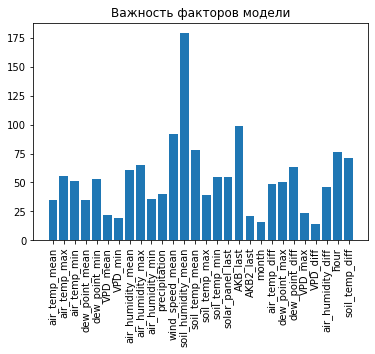

In [124]:
fig, ax = plt.subplots()
plt.title("Важность факторов модели")
plt.bar(range(len(model_LGBM.best_estimator_.feature_importances_)), model_LGBM.best_estimator_.feature_importances_)
plt.xticks(np.arange(len(model_LGBM.best_estimator_.feature_importances_)), features_train.columns, rotation=90)
plt.show()

Все признаки достаточно влияют на результат, поэтому убирать какой то из них нецелесообразно.

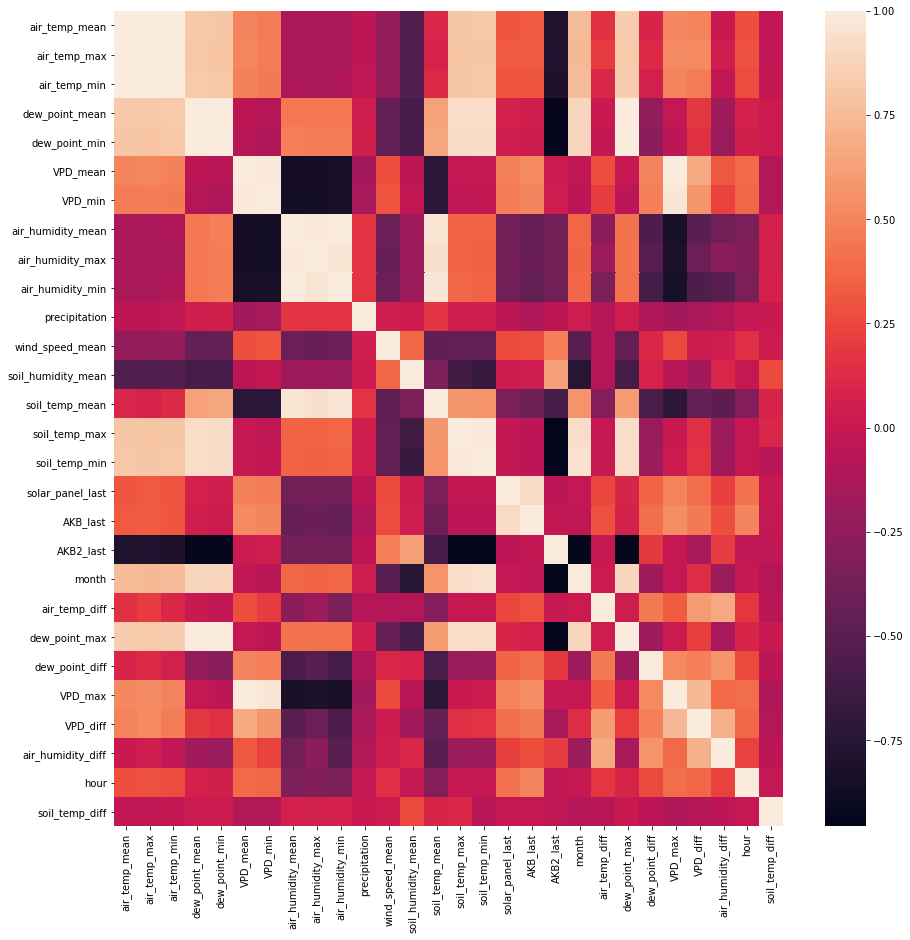

In [125]:
fig, ax = plt.subplots(1, figsize=(15,15))
sns.heatmap(station_data.drop(['leaf_humidity_min'], axis=1).corr());

In [126]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3527 entries, 0 to 3526
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp_mean       3527 non-null   float64
 1   air_temp_max        3527 non-null   float64
 2   air_temp_min        3527 non-null   float64
 3   dew_point_mean      3527 non-null   float64
 4   dew_point_min       3527 non-null   float64
 5   VPD_mean            3527 non-null   float64
 6   VPD_min             3527 non-null   float64
 7   air_humidity_mean   3527 non-null   float64
 8   air_humidity_max    3527 non-null   float64
 9   air_humidity_min    3527 non-null   float64
 10  precipitation       3527 non-null   float64
 11  leaf_humidity_min   3527 non-null   int64  
 12  wind_speed_mean     3527 non-null   float64
 13  soil_humidity_mean  3527 non-null   float64
 14  soil_temp_mean      3527 non-null   float64
 15  soil_temp_max       3527 non-null   float64
 16  soil_t

<code>air_temp_mean</code>, <code>air_temp_max</code>, <code>air_temp_min</code> коррелируют между собой. Оставим только среднюю. 

In [127]:
station_data = station_data.drop(['air_temp_max', 'air_temp_min'], axis=1)

<code>air_humidity_mean</code>, <code>air_humidity_max</code>, <code>air_humidity_min</code> - так же коррелируют

In [128]:
station_data = station_data.drop(['air_humidity_max', 'air_humidity_min'], axis=1)

<code>soil_temp_mean</code>, <code>soil_temp_max</code> и <code>soil_temp_min</code> - также 

In [129]:
station_data = station_data.drop(['soil_temp_max', 'soil_temp_min'], axis=1)

<code>VPD_mean</code>, <code>VPD_min</code> и <code>VPD_max</code>

In [130]:
station_data = station_data.drop(['VPD_max', 'VPD_min'], axis=1)

<code>dew_point_mean</code>, <code>dew_point_min</code> и <code>dew_point_max</code> 

In [131]:
station_data = station_data.drop(['dew_point_max', 'dew_point_min'], axis=1)

### Модель градиентного бустинга с измененными признаками

In [132]:
# разбивка на обучающую и тестовую выборки
#Создание обучающей выборки (75% данных)
train, test = train_test_split(station_data, test_size=0.25, random_state=12345)

In [133]:
#Разбиение на признаки и целевой признак
print('Обучающая выборка')
features_train, target_train=features_target(train, 'leaf_humidity_min')
print('Тестовая выборка')
features_test, target_test=features_target(test, 'leaf_humidity_min')

Обучающая выборка
Объекты: (2645, 18)
Целевой признак: (2645,)
Тестовая выборка
Объекты: (882, 18)
Целевой признак: (882,)


In [134]:
model_LGBM = LGBM(features_train, target_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=10; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=10; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=20; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=20; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=30; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=30; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=10, n_features=40; total time=   0.0s
[LightGBM] [War

[CV] END .....................n_estimators=80, n_features=40; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=80, n_features=40; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=10; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=10; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=20; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=20; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=30; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: n_features
[CV] END .....................n_estimators=90, n_features=30; total time=   

In [135]:
# модель градиентного бустинга
predict_LGBM = model_LGBM.predict(features_test)
mae = mean_absolute_error(target_test, predict_LGBM)
print('---Тестовая выборка---')
print('MAE = {:.2f}'. format(mae))

---Тестовая выборка---
MAE = 7.91


### Модель линейной регрессии с измененными признаками

In [136]:
model_Regression = Regression(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
----Наилучшая модель----
LinearRegression()
MAE = 15.24


In [137]:
# модель линейной регрессии
predict_Regression = model_Regression.predict(features_test)
mae = mean_absolute_error(target_test, predict_Regression)
print('---Тестовая выборка---')
print('MAE = {:.2f}'. format(mae))

---Тестовая выборка---
MAE = 15.36


### Вывод

Не всегда мультиколлинеарность плохо влияет на результат модели, при удалении коррелирующих признаков предсказание градиентного бустинга чуть ухудшилось, но все таки модель осталась самой результативной.

## Вывод

Для дальнейших исследований и построения адекватной модели необходим сбор статистики по многим комплексам, так как один комплекс не дает полной картины и модель может быть применена только для ограниченных климатических данных. Полнота данных вполне позволит предсказывать влажность листа, исходя из внешних параметров, заменяя датчики влажности листа.

Также необходимо следить за настройками станций для сбора корректных данных, так как их качество лежит в основе корректных моделей предсказания.

В результате анализа было выявлено, что датчик стоял в местности с высокой влажностью, но небольшим числом осадков. Это свойственно для субтропического морского климата. В данном случае необходимо оптимизировать систему поливов, так как среднесуточная влажность почвы, судя по графикам, сильно меняется.